
## PROJET FINAL - Prédiction churns opérateurs téléphoniques
Dataset Churns https://www.kaggle.com/datasets/kapturovalexander/customers-churned-in-telecom-services?resource=download
"""

In [2]:
#Dataset transac metaverse: https://www.kaggle.com/datasets/faizaniftikharjanjua/metaverse-financial-transactions-dataset
#pip install pandas numpy matplotlib seaborn sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [3]:
df = pd.read_csv('customer_churn_telecom_services.csv')  # chargement données

## PIPELINE ##
#### Extract (exploration et analyse)

In [5]:
print("Colonnes disponibles :", df.columns.tolist())

print(df.head()) #aperçu de la df 
print(df.describe()) #donne les stat, moyennes, quartiles, min, max. 
print(df.isnull().sum()) # Vérification des valeurs manquantes
print(df.duplicated().sum()) # Vérification des doublons
for col in df.select_dtypes(include='object').columns: #quels valeurs possibles par catégorie
    print(f"\n{col}: {df[col].unique()}")


Colonnes disponibles : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes       

/var/folders/9r/mg4gblmx0ml2wjrblqpzzchw0000gn/T/ipykernel_23528/3818587980.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='coolwarm')


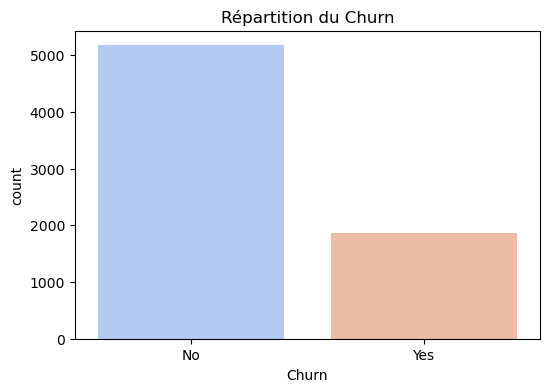

In [6]:
# Distribution graph churns
plt.figure(figsize=(6,4)) 
sns.countplot(x='Churn', data=df, palette='coolwarm')
plt.title('Répartition du Churn')
plt.show()

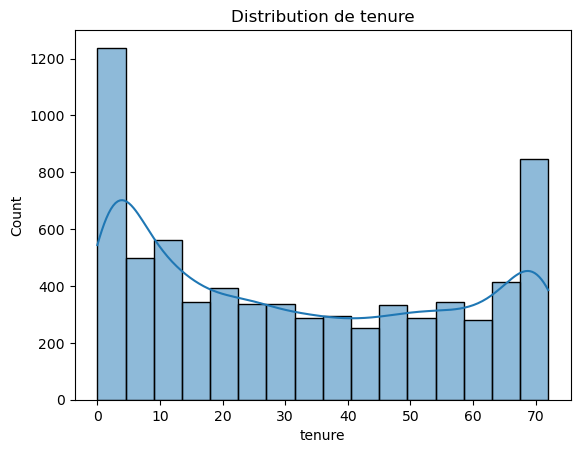

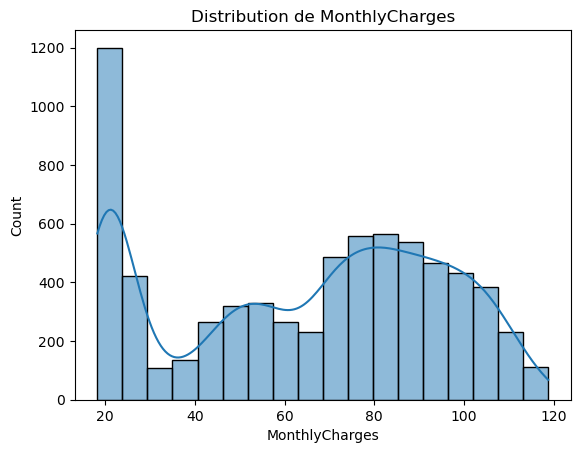

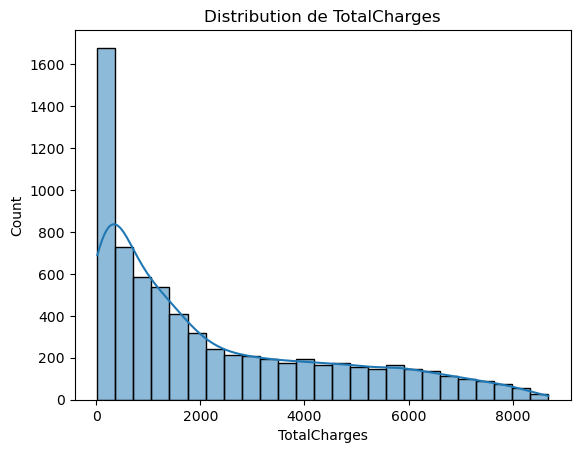

In [7]:
# distribution des frais / durée abonnement
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges'] 
for feature in numerical_features:
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution de {feature}')
    plt.show()

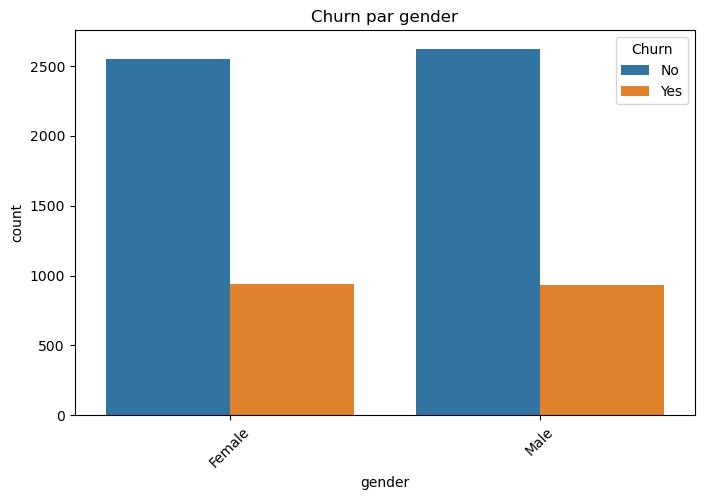

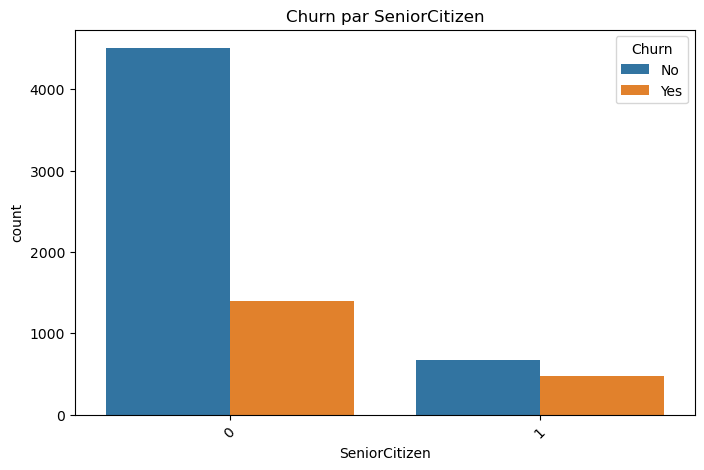

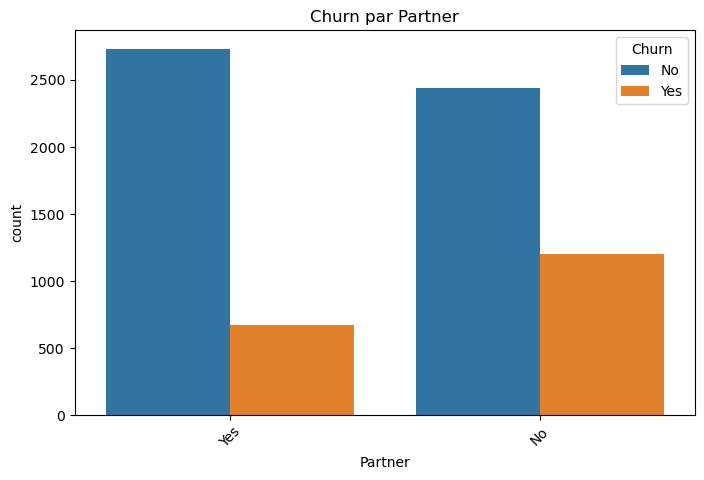

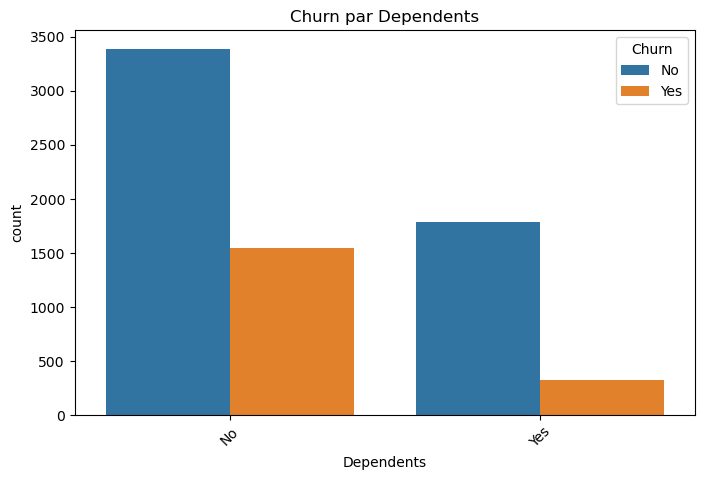

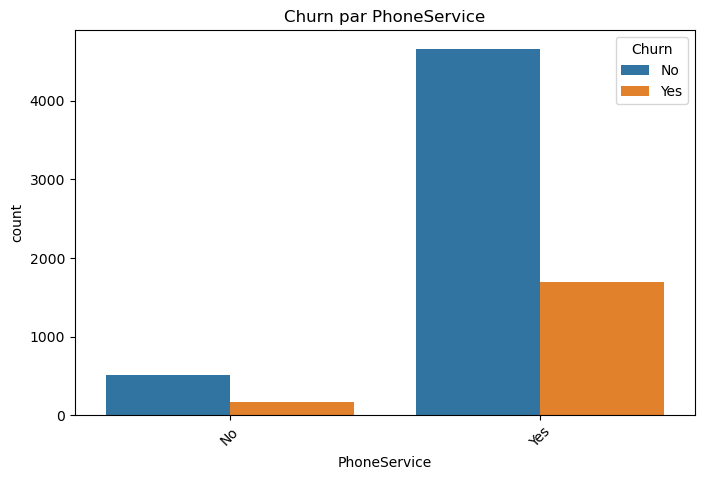

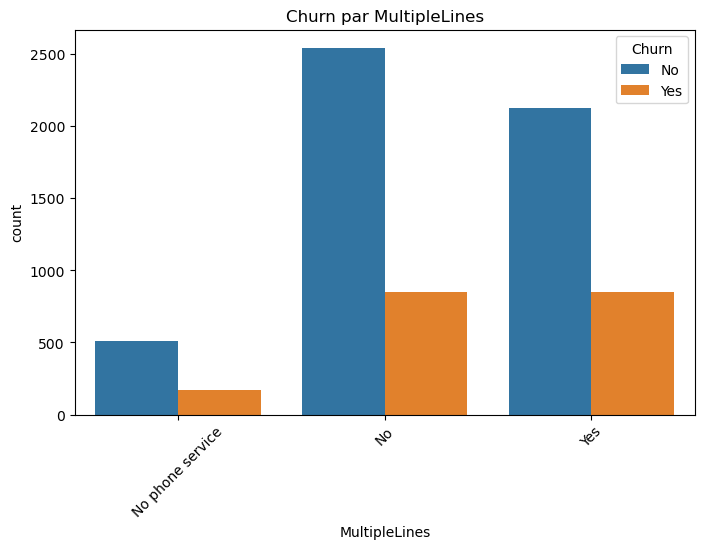

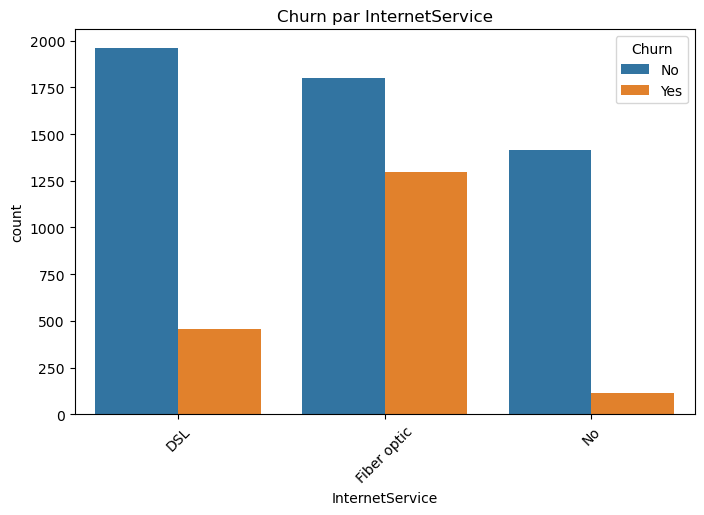

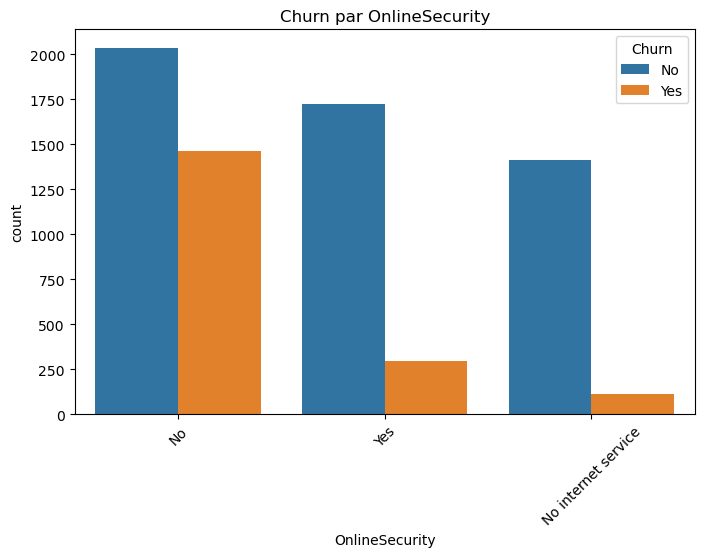

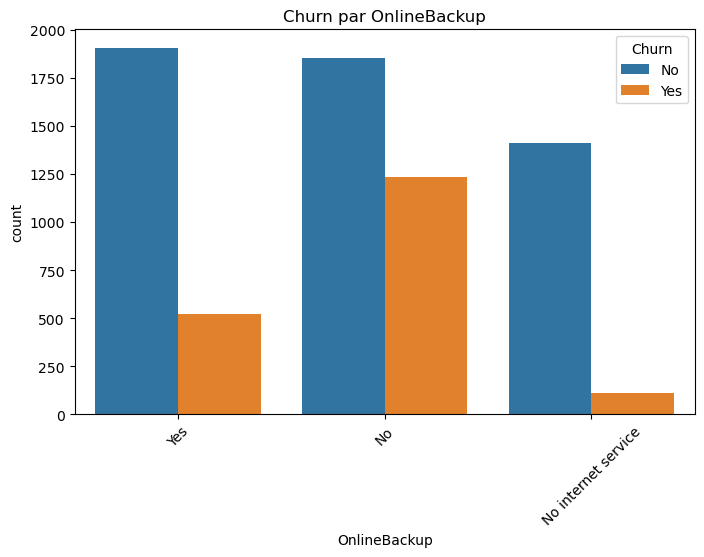

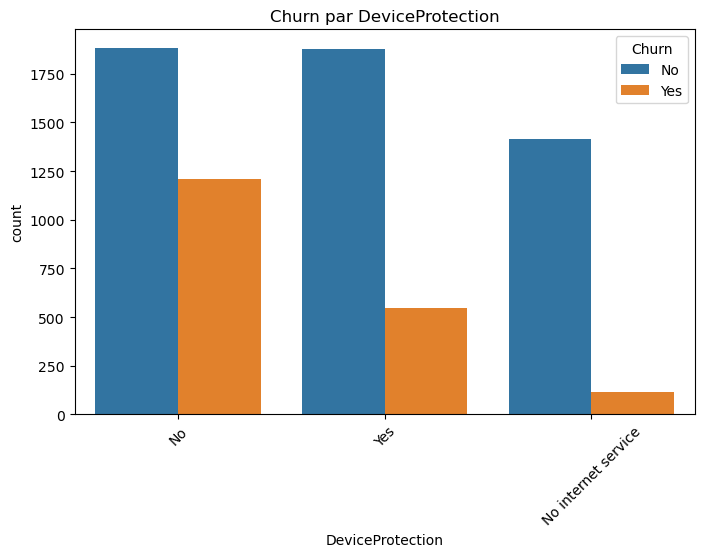

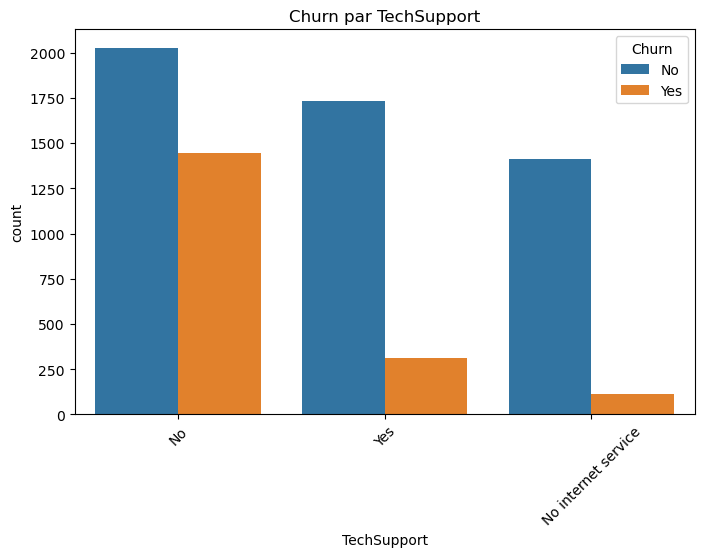

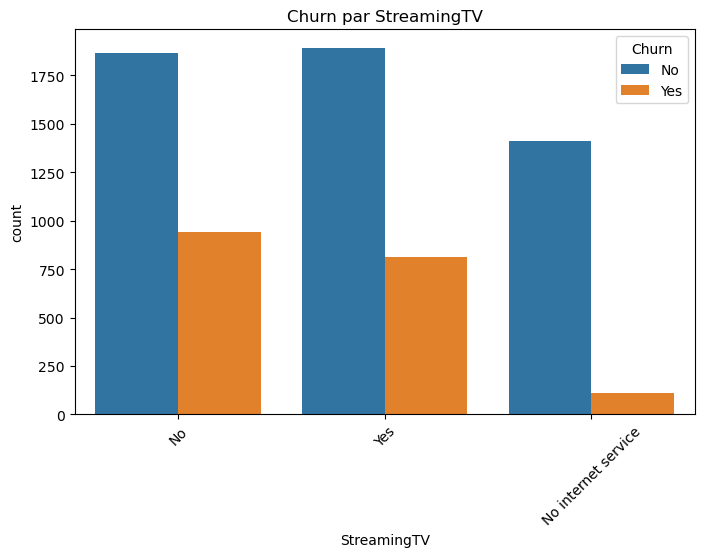

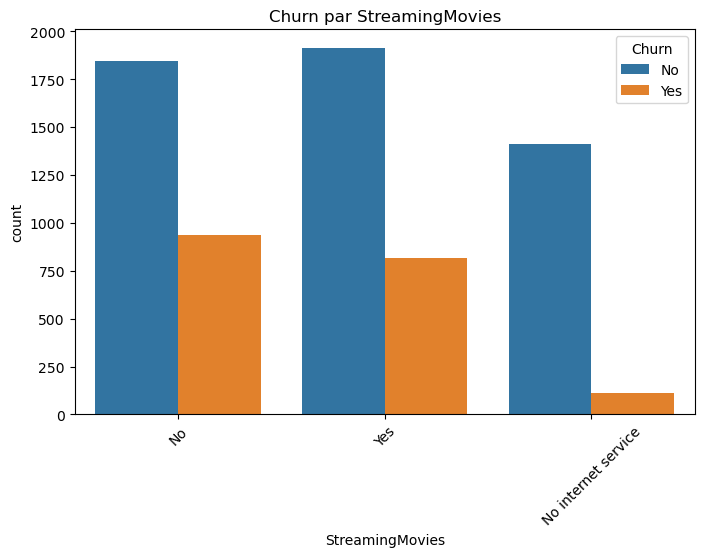

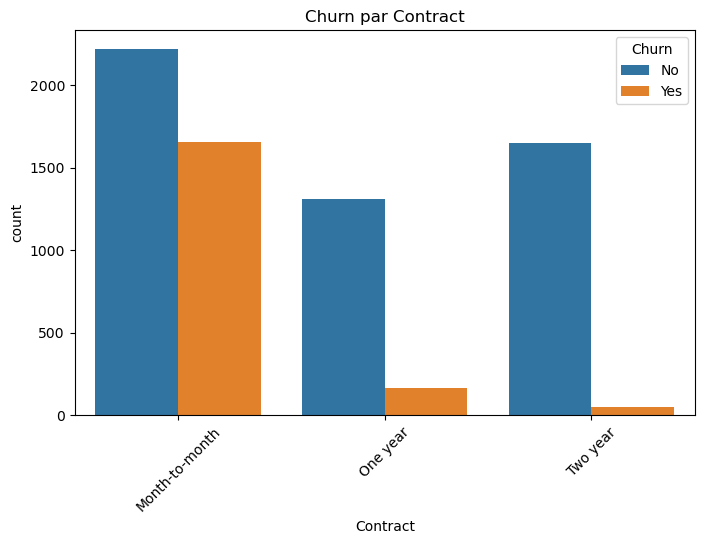

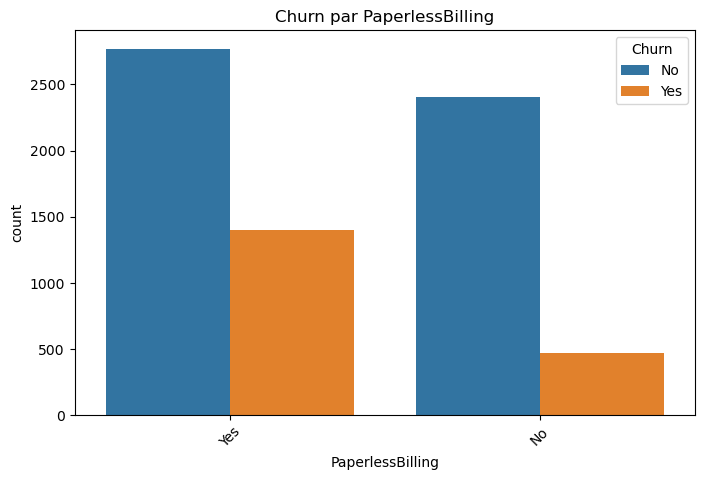

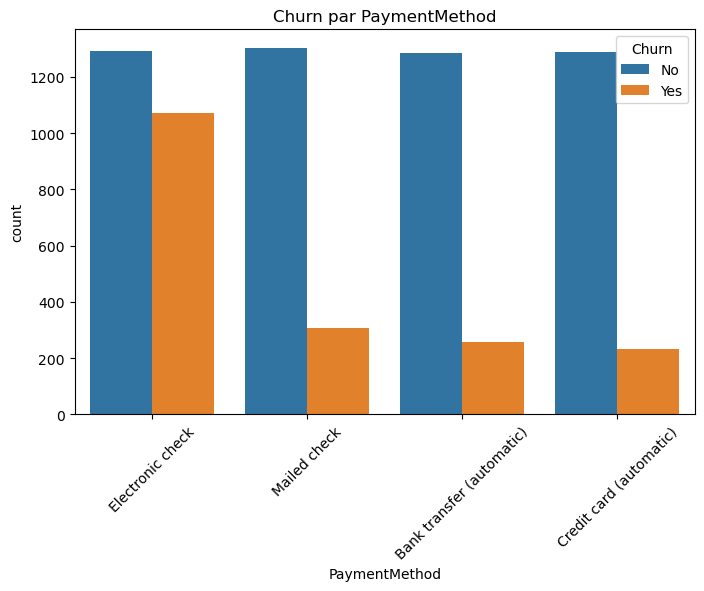

In [8]:
# Relation entre les variables catégorielles et le churn
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']
for feature in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature, hue='Churn', data=df)
    plt.title(f'Churn par {feature}')
    plt.xticks(rotation=45)
    plt.show()


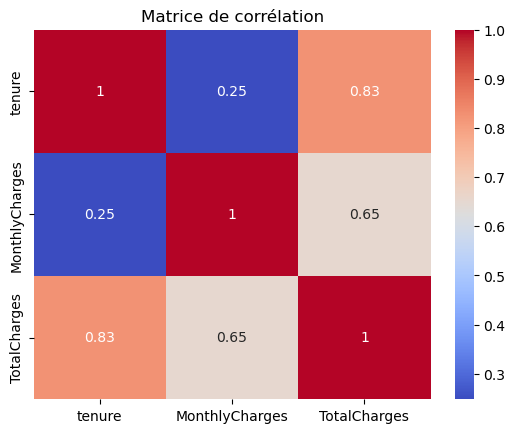

In [9]:
# Matrice de corrélation pour les charges et durée des abonnements
correlation = df[numerical_features].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

## Transform ##

/var/folders/9r/mg4gblmx0ml2wjrblqpzzchw0000gn/T/ipykernel_23528/1393329843.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


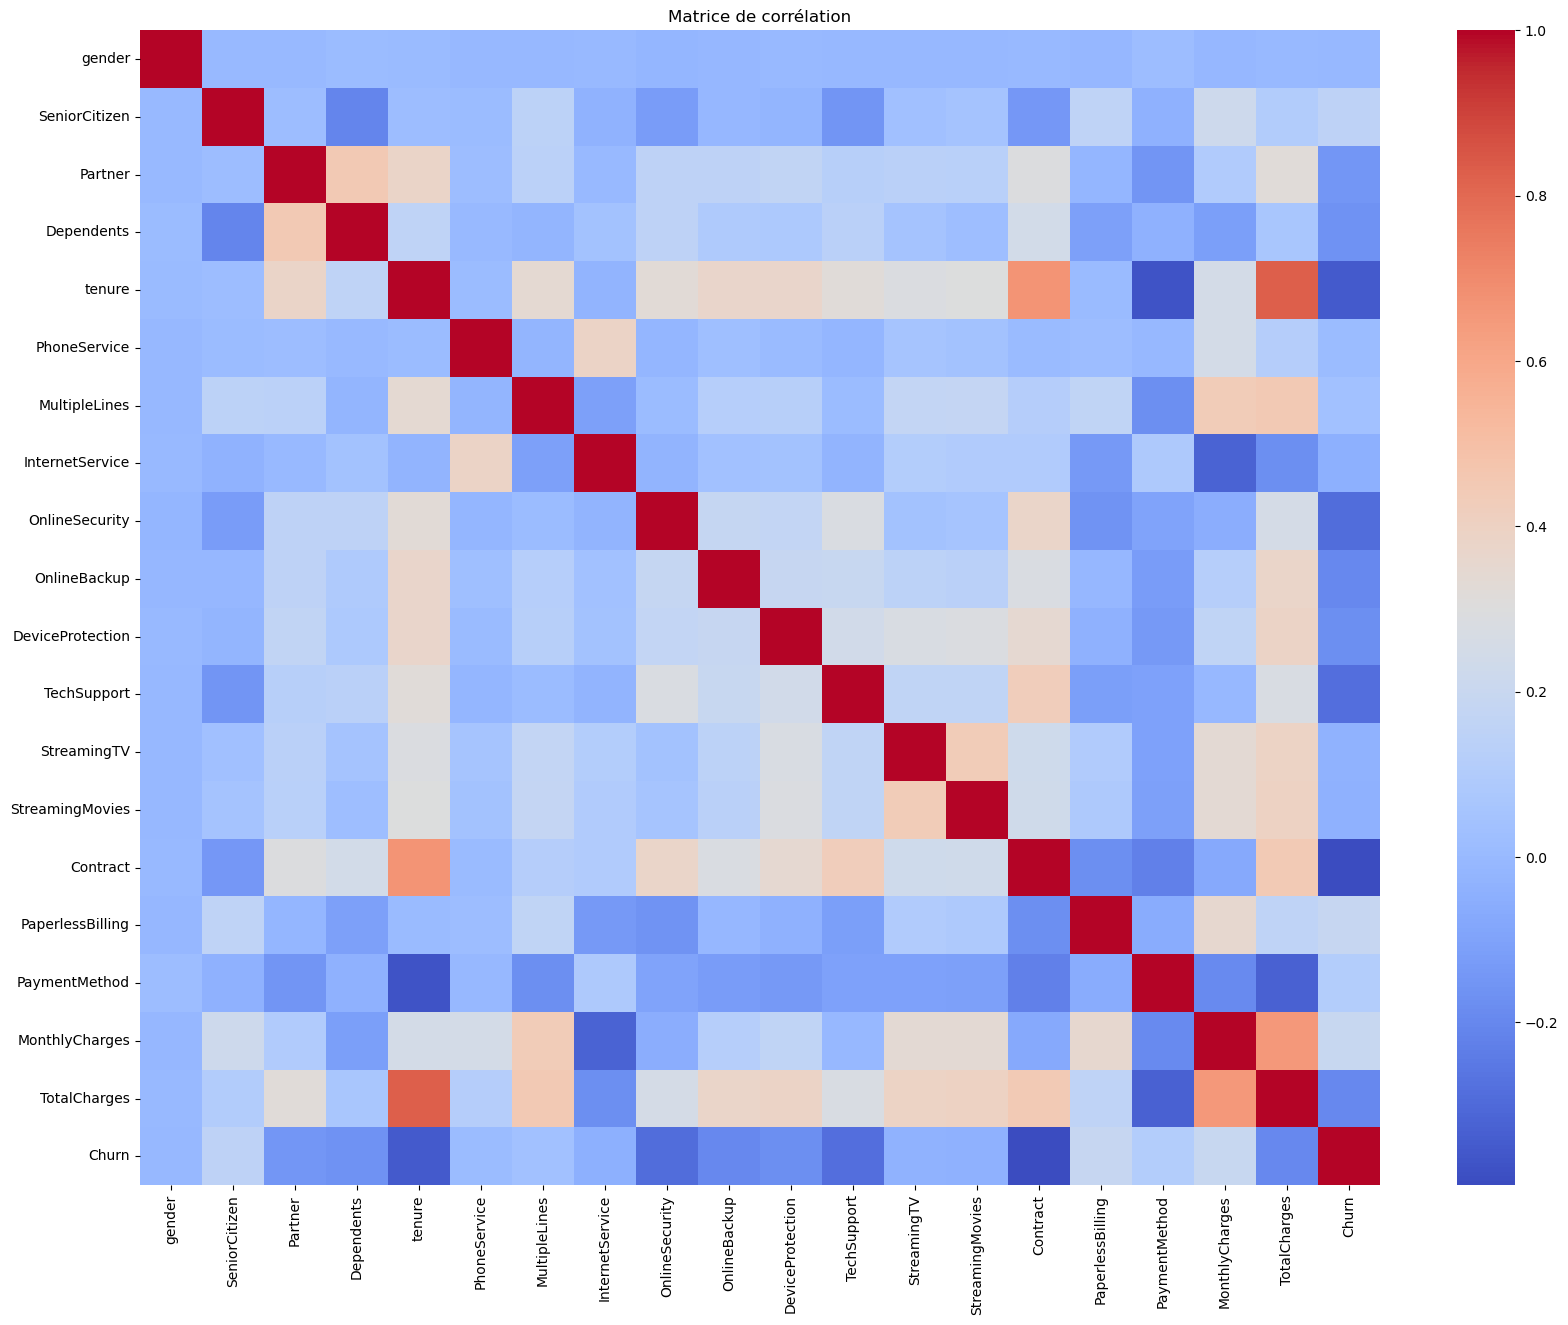

In [11]:
# Nettoyage valeurs manquantes dans colonnes importantes
important_columns = ['Contract', 'tenure', 'MonthlyCharges', 'PhoneService', 'InternetService']
df.dropna(subset=important_columns, inplace=True)

# convertit 'TotalCharges' en numérique + gère les valeurs manquantes
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Encodage des variables catégorielles en valeurs numériques
label_encoders = {} 
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Dummies / one-hot encoding pour  variables catégorielles
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# normalisation variables numériques, assure que toutes les variables numériques sont à la même échelle
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Séparation des données en données d'entrainement et de test
X = df.drop(columns=['Churn']) 
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Matrice de corrélation var catégorielles
correlation_matrix = df.corr() # Calcul 
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Matrice de corrélation')
plt.show()

# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Load si nécessaire ##

## ML ##


Random Forest Model Performance:
Accuracy: 0.7963094393186657
ROC AUC Score: 0.8370006831803078
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1036
           1       0.66      0.47      0.55       373

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409



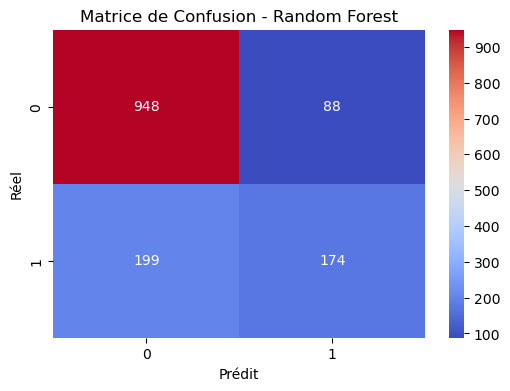


Gradient Boosting Model Performance:
Accuracy: 0.8055358410220014
ROC AUC Score: 0.8580045959402528
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.67      0.52      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



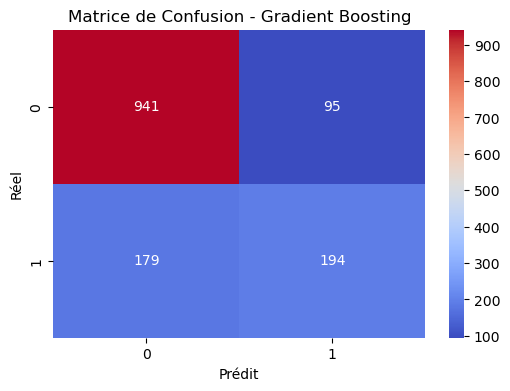


SVM Model Performance:
Accuracy: 0.8069552874378992
ROC AUC Score: 0.813167006531618
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.87      1036
           1       0.68      0.50      0.58       373

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



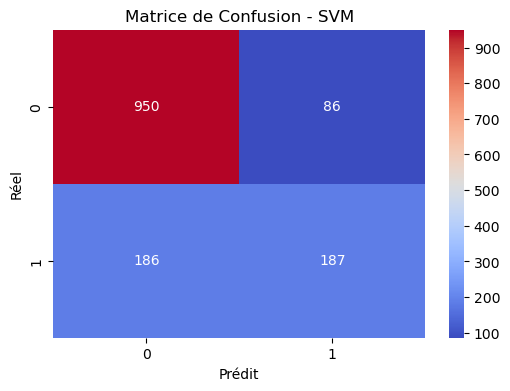


KNN Model Performance:
Accuracy: 0.7579843860894251
ROC AUC Score: 0.7789963460204747
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1036
           1       0.55      0.50      0.52       373

    accuracy                           0.76      1409
   macro avg       0.69      0.68      0.68      1409
weighted avg       0.75      0.76      0.75      1409



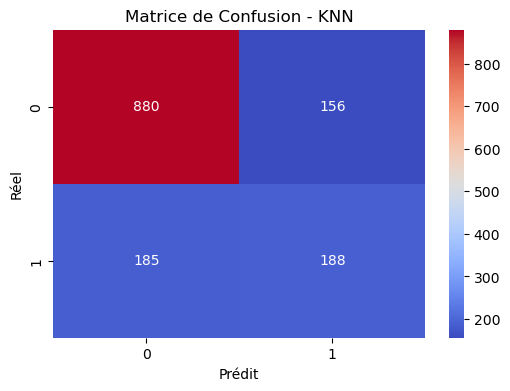


Régression logistique Model Performance:
Accuracy: 0.815471965933286
ROC AUC Score: 0.861354508472471
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.58      0.62       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



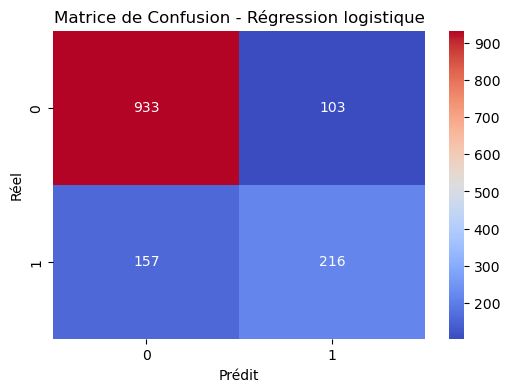

In [14]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Régression logistique": LogisticRegression()
}

# Entraînement + évaluation des modèles
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    print(f"\n{name} Model Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Matrice de confusion
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm')
    plt.title(f'Matrice de Confusion - {name}')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.show()




Résultats de la Cross-Validation :
Random Forest: 0.7894
Gradient Boosting: 0.8055
SVM: 0.7967
KNN: 0.7669
Régression logistique: 0.8021


/var/folders/9r/mg4gblmx0ml2wjrblqpzzchw0000gn/T/ipykernel_23528/3188212362.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="coolwarm")


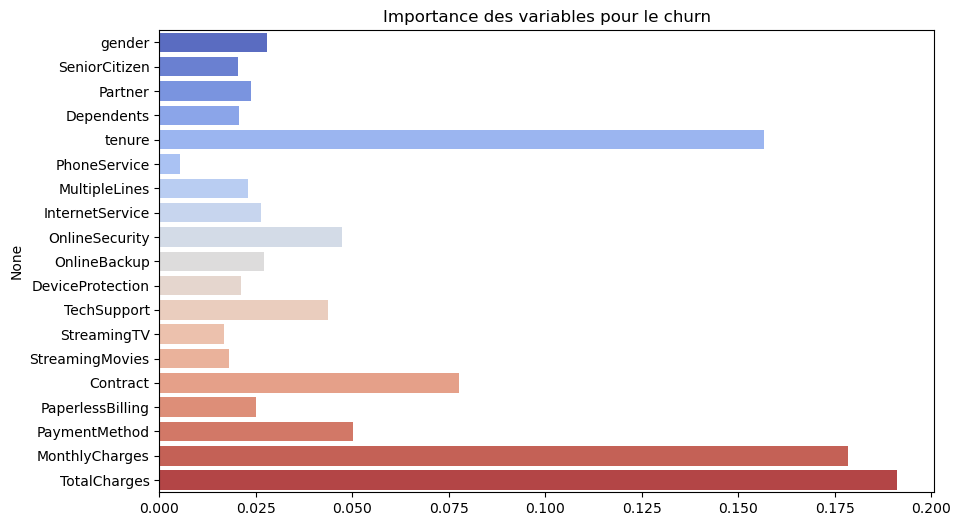

/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



Top 10 clients les plus à risque de churn :
      Client_Index  Churn_Probability    tenure  Contract  MonthlyCharges  \
6714          6714               0.46 -0.788800         0        1.196105   
4428          4428               0.42 -0.544478         0        1.280857   
171            171               0.42 -1.236724         0        1.317416   
2208          2208               0.42 -1.277445         0        1.197767   
630            630               0.42  0.432811         0        1.528465   
6838          6838               0.42 -0.788800         0        1.137942   
6821          6821               0.42 -0.585198         0        1.166193   
5581          5581               0.41  1.450820         2        1.608231   
6166          6166               0.40 -0.055834         0        1.310769   
898            898               0.40 -0.829521         0        1.134619   

      TotalCharges  
6714     -0.427647  
4428     -0.118854  
171      -0.900229  
2208     -0.962919  
63

In [15]:
# Cross-validation pour chaque modèle
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # Cross-validation 5-fold
    cv_results[name] = scores.mean()  # Moyenne des scores

# résultats  cross-validation
print("\nRésultats de la Cross-Validation :")
for model, score in cv_results.items():
    print(f"{model}: {score:.4f}")

#### Facteurs de résiliation
importances = models["Random Forest"].feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feature_names, palette="coolwarm")
plt.title("Importance des variables pour le churn")
plt.show()

#### Segmentation clients à risque (10 plus à risque de churn)
df['Churn_Probability'] = models["Random Forest"].predict_proba(X)[:, 1]
df['Client_Index'] = df.index  # Utiliser l'index comme identifiant client

top_churners = df[['Client_Index', 'Churn_Probability', 'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']]\
                .sort_values(by='Churn_Probability', ascending=False)\
                .head(10)

print("\nTop 10 clients les plus à risque de churn :")
print(top_churners)

In [53]:
!pip install xgboost
!pip install shap
!pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00


Suppression de la variable avec VIF le plus élevé (PhoneService_Yes)
Suppression de la variable avec VIF le plus élevé (engagement_score)
Suppression de la variable avec VIF le plus élevé (tenure)
                                  Feature       VIF
2                      avg_monthly_charge  7.775861
8             InternetService_Fiber optic  5.293903
1                            TotalCharges  4.262082
19         PaymentMethod_Electronic check  3.667687
17                   PaperlessBilling_Yes  3.659807
14                    StreamingMovies_Yes  3.174269
13                        StreamingTV_Yes  3.134164
7                       MultipleLines_Yes  2.732296
4                             Partner_Yes  2.626483
16                      Contract_Two year  2.276369
11                   DeviceProtection_Yes  2.231241
3                             gender_Male  2.121693
10                       OnlineBackup_Yes  2.067826
20             PaymentMethod_Mailed check  2.029035
5                      

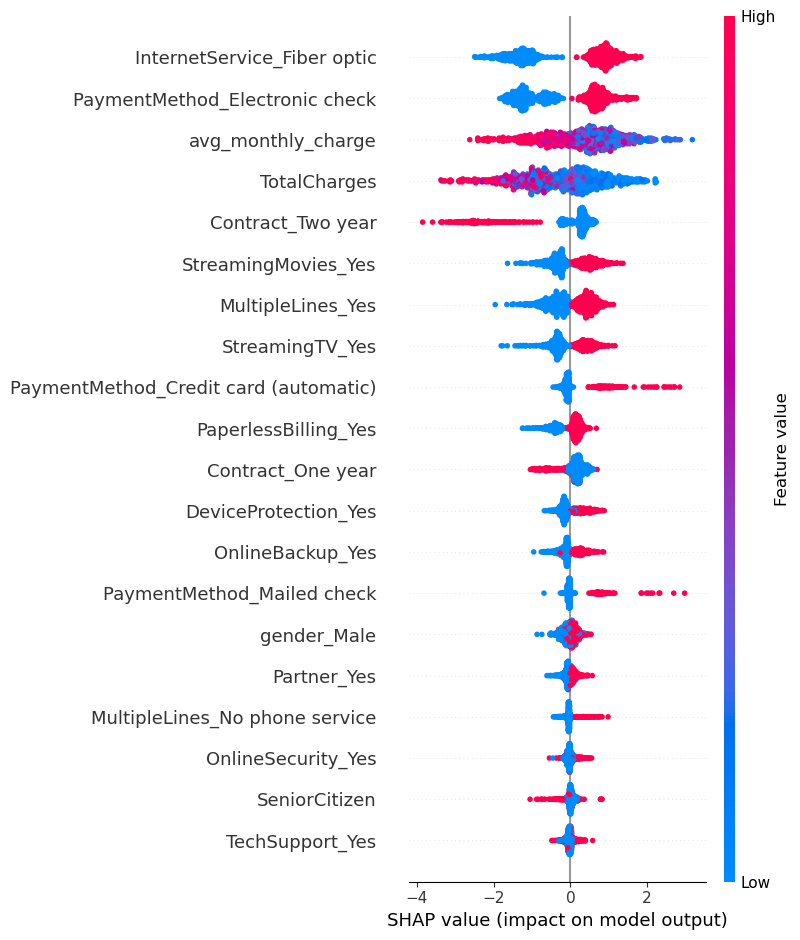

In [63]:
# 📌 Importation des librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

# 📌 Chargement des données
df = pd.read_csv('customer_churn_telecom_services.csv')

# 📌 Nettoyage des noms de colonnes
df.columns = df.columns.str.strip()

# 📌 Conversion de la colonne cible 'Churn' en valeurs numériques
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 📌 Création de nouvelles features
df['avg_monthly_charge'] = df['TotalCharges'] / (df['tenure'] + 1)  # Évite division par zéro
df['engagement_score'] = df['tenure'] * 0.2 + df['PaperlessBilling'].map({'Yes': 1, 'No': 0}) * 1.2 + df['Contract'].map({'Two year': 4, 'One year': 2, 'Month-to-month': 0})

# 📌 Normalisation des variables continues
scaler = StandardScaler()
df[['TotalCharges', 'avg_monthly_charge', 'engagement_score']] = scaler.fit_transform(df[['TotalCharges', 'avg_monthly_charge', 'engagement_score']])

# 📌 Encodage des variables catégoriques
df = pd.get_dummies(df, drop_first=True)

# 📌 Suppression des variables inutiles
df = df.drop(columns=['MonthlyCharges', 'num_services'], errors='ignore')

# 📌 Vérification et remplissage des valeurs manquantes avant SMOTE
df.fillna(df.median(), inplace=True)

# 📌 Séparation des features et de la target
y = df['Churn']
X = df.drop(columns=['Churn'])

# 📌 Application de SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 📌 Suppression des variables avec colinéarité parfaite pour éviter les VIF infinis
cols_to_remove = [
    'OnlineSecurity_No internet service', 'OnlineBackup_No internet service',
    'StreamingMovies_No internet service', 'StreamingTV_No internet service',
    'TechSupport_No internet service', 'DeviceProtection_No internet service',
    'InternetService_No'
]
X_resampled = X_resampled.drop(columns=cols_to_remove, errors='ignore')

# 📌 Nettoyage des valeurs infinies et NaN avant calcul du VIF
X_resampled = X_resampled.replace([np.inf, -np.inf], np.nan)
X_resampled.fillna(X_resampled.median(), inplace=True)

# 📌 Conversion de toutes les colonnes en float64
X_resampled = X_resampled.astype('float64')

# 📌 Calcul du VIF avec gestion des erreurs
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = np.nan  # Initialisation avec NaN pour éviter les erreurs

    for i in range(X.shape[1]):
        try:
            vif_data.loc[i, "VIF"] = variance_inflation_factor(X.values, i)
        except Exception as e:
            print(f"⚠️ Erreur VIF sur {X.columns[i]}: {e}")
            vif_data.loc[i, "VIF"] = np.nan  # Évite que l'erreur bloque le code
    return vif_data

vif_data = calculate_vif(X_resampled)

# 📌 Suppression progressive des variables avec un VIF > 10
while vif_data["VIF"].max() > 10:
    feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
    print(f"Suppression de la variable avec VIF le plus élevé ({feature_to_remove})")
    X_resampled = X_resampled.drop(columns=[feature_to_remove])
    vif_data = calculate_vif(X_resampled)

print(vif_data.sort_values(by="VIF", ascending=False))

# 📌 Modèles avec optimisation des hyperparamètres
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'SVM': SVC(probability=True, class_weight='balanced'),
    'KNN': KNeighborsClassifier()
}

# 📌 Validation croisée
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='roc_auc')
    print(f"{name}: Mean ROC-AUC = {scores.mean():.4f}")

# 📌 Optimisation des hyperparamètres pour XGBoost et GradientBoosting
param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}
xgb_search = RandomizedSearchCV(XGBClassifier(eval_metric='logloss'), param_grid_xgb, n_iter=10, cv=5, scoring='roc_auc', random_state=42)
xgb_search.fit(X_resampled, y_resampled)
print("Best parameters for XGBoost: ", xgb_search.best_params_)

param_grid_gb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}
gb_search = RandomizedSearchCV(GradientBoostingClassifier(), param_grid_gb, n_iter=10, cv=5, scoring='roc_auc', random_state=42)
gb_search.fit(X_resampled, y_resampled)
print("Best parameters for Gradient Boosting: ", gb_search.best_params_)

# 📌 ÉCHANTILLONNAGE POUR SHAP 🔴
X_sample = X_resampled.sample(n=1000, random_state=42)  # Ajustable selon la RAM

# 📌 Analyse SHAP pour expliquer les prédictions
explainer = shap.TreeExplainer(xgb_search.best_estimator_)  # Explication avec XGBoost optimisé
shap_values = explainer.shap_values(X_sample.to_numpy())
shap.summary_plot(shap_values, X_sample)


# Suppression de la variable avec VIF le plus élevé (PhoneService_Yes) pour tester

VIF après suppression de PhoneService_Yes:
                                  Feature        VIF
3                            TotalCharges  10.497161
2                          MonthlyCharges   9.390822
1                                  tenure   8.744700
9             InternetService_Fiber optic   6.991146
20         PaymentMethod_Electronic check   3.706265
18                   PaperlessBilling_Yes   3.453570
14                        StreamingTV_Yes   3.176726
15                    StreamingMovies_Yes   3.124606
17                      Contract_Two year   2.831411
5                             Partner_Yes   2.644862
8                       MultipleLines_Yes   2.553219
21             PaymentMethod_Mailed check   2.363331
12                   DeviceProtection_Yes   2.217948
4                             gender_Male   2.031791
11                       OnlineBackup_Yes   1.996470
13                        TechSupport_Yes   1.932087
19  PaymentMethod_Credit card (automatic)   1.897637
16 

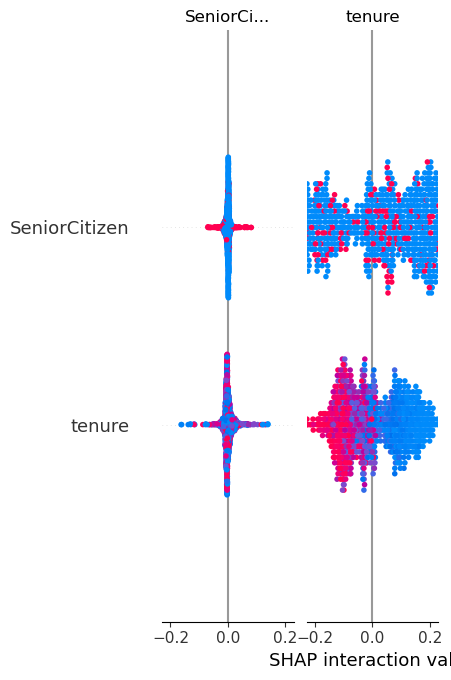

In [27]:

X_resampled_no_phone_service = X_resampled.drop(columns=['PhoneService_Yes'], errors='ignore')

# Recalcul du VIF après suppression
vif_data_no_phone_service = pd.DataFrame()
vif_data_no_phone_service['Feature'] = X_resampled_no_phone_service.columns
vif_data_no_phone_service['VIF'] = [variance_inflation_factor(X_resampled_no_phone_service.values, i) for i in range(X_resampled_no_phone_service.shape[1])]
print("VIF après suppression de PhoneService_Yes:")
print(vif_data_no_phone_service.sort_values(by='VIF', ascending=False))

# Réentraîner un modèle RandomForest sans PhoneService_Yes
rf_no_phone_service = RandomForestClassifier(random_state=42)
rf_no_phone_service.fit(X_resampled_no_phone_service, y_resampled)

# Validation croisée
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X_resampled_no_phone_service, y_resampled, cv=kf, scoring='roc_auc')
    print(f"{name} (sans PhoneService_Yes): Mean ROC-AUC = {scores.mean():.4f}")

# Analyse SHAP pour expliquer les prédictions sans PhoneService_Yes
X_sample_no_phone_service = X_resampled_no_phone_service.sample(n=1000, random_state=42)  # Ajustable selon la RAM
explainer_no_phone_service = shap.TreeExplainer(rf_no_phone_service)
shap_values_no_phone_service = explainer_no_phone_service.shap_values(X_sample_no_phone_service.to_numpy())
shap.summary_plot(shap_values_no_phone_service, X_sample_no_phone_service)


# Sélection automatique des features avec RFE (Recursive Feature Elimination)

Features sélectionnées avec RFE: Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Male',
       'Partner_Yes', 'InternetService_Fiber optic', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Electronic check'],
      dtype='object')
Logistic Regression (avec features sélectionnées par RFE): Mean ROC-AUC = 0.8490
Random Forest (avec features sélectionnées par RFE): Mean ROC-AUC = 0.8869
Gradient Boosting (avec features sélectionnées par RFE): Mean ROC-AUC = 0.8764
XGBoost (avec features sélectionnées par RFE): Mean ROC-AUC = 0.8904
SVM (avec features sélectionnées par RFE): Mean ROC-AUC = 0.8456
KNN (avec features sélectionnées par RFE): Mean ROC-AUC = 0.8526


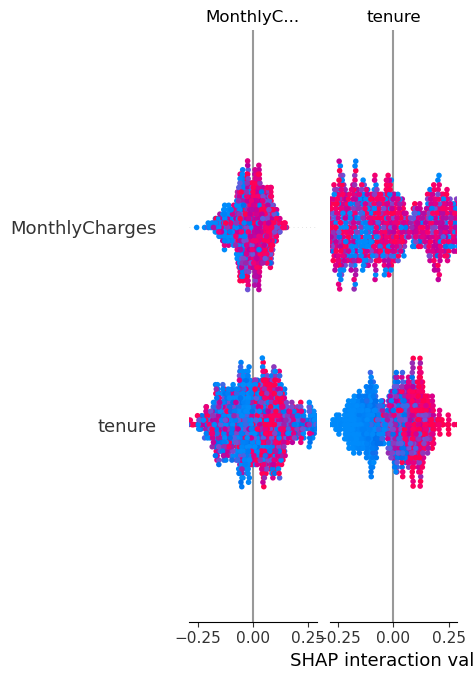

In [35]:
from sklearn.feature_selection import mutual_info_classif, RFE
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor

selector = RFE(RandomForestClassifier(random_state=42), n_features_to_select=10)
selector.fit(X_resampled_no_phone_service, y_resampled)

# Affichage des features sélectionnées
selected_features = X_resampled_no_phone_service.columns[selector.support_]
print("Features sélectionnées avec RFE:", selected_features)

# Réentraîner un modèle RandomForest avec uniquement les features sélectionnées
X_resampled_selected = X_resampled_no_phone_service[selected_features]
rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_resampled_selected, y_resampled)

# Validation croisée
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X_resampled_selected, y_resampled, cv=kf, scoring='roc_auc')
    print(f"{name} (avec features sélectionnées par RFE): Mean ROC-AUC = {scores.mean():.4f}")

# Analyse SHAP pour expliquer les prédictions avec les features sélectionnées
X_sample_selected = X_resampled_selected.sample(n=1000, random_state=42)
explainer_selected = shap.TreeExplainer(rf_selected)
shap_values_selected = explainer_selected.shap_values(X_sample_selected.to_numpy())
shap.summary_plot(shap_values_selected, X_sample_selected)

## Clustering

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

sns.pairplot(df, hue='Cluster', vars=['tenure', 'MonthlyCharges', 'TotalCharges'])
plt.show()


## Contenairisation etc 

In [ ]:
print(X_resampled.dtypes.value_counts())  # Vérifie le type des colonnes
print(X_resampled.select_dtypes(exclude=['number']).columns)  # Liste les colonnes non numériques
